In [1]:
#Alternative : 
#import files
#from local_navigation import prox
#import class
#from thymioV2 import thymio_robot
#import librairies
import time
import numpy as np
import math 
import cv2
import matplotlib.pyplot as plt


In [2]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node() #_ = protected #__ = private = shouldn't access node outside of the class
await node.lock()

Node ad6b0acc-2bf0-4a27-bb7a-64d9d8bda21d

In [4]:
await th.stop_motor(node)

In [3]:
from src.Motion_Control import thymio as th
from src.Global_Nav import helpers_global as gb
from src.Vision import vision as vs
import filtering 
from src.Local_Nav import psymap as pm  
from src.Local_Nav import local_navigation as ln        
#from src.Vision import vision_test as vs2



In [4]:
MAP_SHAPE = (1000,700)
REFRAME = True 
Ts =0.05

In [5]:
MAP_SHAPE = (1000,700)
REFRAME = True 
cap = cv2.VideoCapture(1)#not 2



[[355.        ]3 samples
 [684.        ]
 [ -1.88736558]
 [  0.        ]
 [  0.        ]]
Initial Map:
Map with optimal path


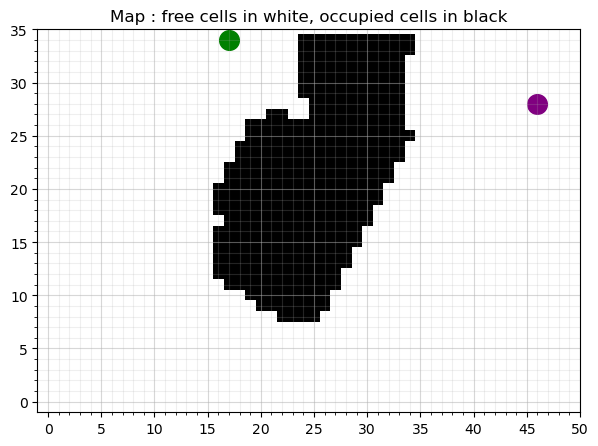

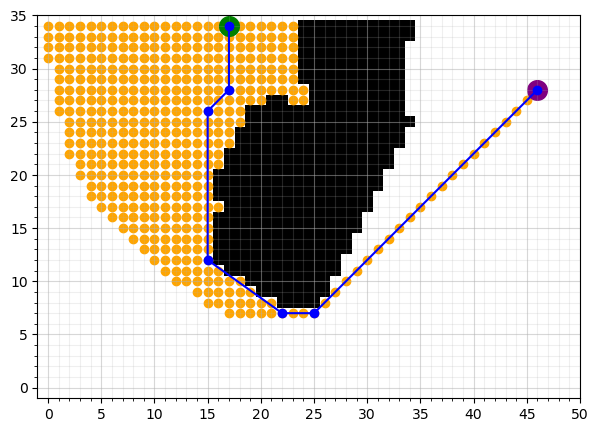

In [7]:


if REFRAME:
    Tmap = vs.get_warp(cap,MAP_SHAPE,10,1)

while True:
    ret,frame = cap.read()
    if ret:
        # maps capture to map
        if REFRAME:
            
            frame = cv2.warpPerspective(frame,Tmap,MAP_SHAPE)
        # maps BGR to HLS color space for simplicity
        HLS = cv2.cvtColor(frame, cv2.COLOR_BGR2HLS_FULL)
        
    
        fmap = vs.get_grid_fixed_map(frame,(50,35),50, robrad=120)
        
        # find dest position
        bool_dest, dest = vs.get_destination(frame)
        
        if bool_dest:
            dest = dest/10.0
            dest[1] = 70-dest[1]
            dest = gb.convert_to_idx(dest,2)
            #dest[1]= 35-dest[1]
            dest = tuple(dest)
        #dest = gb.convert_to_idx(vs.get_destination(frame)/10.0, 2)
        # find robot
            gotpos,robpos,orient, ppmx = vs.get_Robot_position_orientation(HLS,5)
            if gotpos : 
                start=robpos
                start[1]= 700 -start[1]
                state_estimation_prev2 = np.array([[start[0]],[start[1]], [orient], [0],[0]])
                start = start/10.0
                print(state_estimation_prev2)
                start = gb.convert_to_idx(start,2)
                start = tuple(start)
                path = gb.global_final(fmap,start,dest, "8N", True)
                P_estimation_prev = 1000*np.ones(5)
                break
        

In [ ]:
 np.array([[0],[1], [4], [0],[0]])

In [ ]:
def kidnapping(bottom_sensors):
    if (bottom_sensors<1000):
        print("Kidnapping detected")
        #recompute A*
        


In [8]:
def next_checkpoint2(path, position, counter,local_obstacle):
    if counter < len(path) - 1:
        x1, y1 = path[counter]
        x2, y2 = path[counter + 1]
        x_est = x1 - position[0]
        y_est = y1 - position[1]
        dist = np.sqrt(x_est ** 2 + y_est ** 2)
        if(local_obstacle and dist<8):
            counter=counter+1
            x1, y1 = path[counter]
            x_est = x1 - position[0]
            y_est = y1 - position[1]
            dist = np.sqrt(x_est ** 2 + y_est ** 2) 
            if dist<10:  
                counter = counter+1  
                counter=counter+1
                x1, y1 = path[counter]
                x_est = x1 - position[0]
                y_est = y1 - position[1]
                dist = np.sqrt(x_est ** 2 + y_est ** 2) 
                if dist <12:
                    counter = counter+1
                    return np.array([path[counter][0], path[counter][1]]), counter
                else : 
                    return np.array([path[counter][0], path[counter][1]]), counter
            else : 
                return np.array([path[counter][0], path[counter][1]]), counter

        if dist < 2:
            counter = counter + 1
            return np.array([path[counter][0], path[counter][1]]), counter

    return np.array([path[counter][0], path[counter][1]]), counter

In [9]:

## Main boucld sans filtering
Ts =0.01
epsilon=np.pi/15 #np.pi/12
local_obstacle = False
counter=0## Main boucld sans filtering
Ts =0.01
epsilon=np.pi/10 #np.pi/12
local_obstacle = False
counter=0
record= []
angle =[]
#check_point_prev =[0,0]
check_point_prev=np.array([0,0])
while True:
    ret,frame = cap.read()
    Tmap = vs.get_warp(cap,MAP_SHAPE,10,1)
    if ret:
        # maps capture to map
        if REFRAME:
            frame = cv2.warpPerspective(frame,Tmap,MAP_SHAPE)
        # maps BGR to HLS color space for simplicity
        HLS = cv2.cvtColor(frame, cv2.COLOR_BGR2HLS_FULL)

        bool_pos ,center,orient, scale = vs.get_Robot_position_orientation(HLS, 5)
        if bool_pos : 
            

            center = center/20.0
            center[1] = 35- center[1]
            x_est_cam = [center[0], center[1], orient]

            record.append(x_est_cam)
           # print(x_est_cam)
            #check_point = gb.next_checkpoint(path, center)
            check_point, counter = gb.next_checkpoint2(path, center, counter)
            
            if check_point_prev != check_point:
                print(f"Le robot est en position de {center}, converti en index {gb.convert_to_idx(center,1)} et le prochain check point est {check_point}")
                #print(checkpoint)
                check_point_prev = check_point
                
            if abs(center[0]-path[-1][0])<0.5 and abs(center[0]-path[-1][0])<0.5:
                await th.stop_motor(node)
                break
            #angle_error=orient-th.compute_angle(gb.convert_to_idx(center,1), check_point)
            angle_error=orient-th.compute_angle(gb.convert_to_idx(center,1), path[counter])
            #print(f"L'angle du robot est {orient} et l'angle vers le goal est {th.compute_angle(gb.convert_to_idx(center,1) , check_point)} et l'angle error est {angle_error}")
            angle.append(angle_error)
            #local nav
            #sensor values
            obscont = vs.get_obstacles(frame)
            capthall = pm.hallucinate_map([center[0],center[1],(-orient)],obscont)
            sens = await th.get_proximity_values(client)
            if (sum(sens[i] > 3500 for i in range(0, 5)) > 0):
                local_obstacle = True

            if(local_obstacle):
                print("local nav on")
                await ln.local_navigation(client,node,[center[0],center[1],(-orient)],obscont)
                if(not sum(sens[i] > 3500 for i in range(0, 5)) > 0):
                    await th.motorset(node,100,100)
                    time.sleep(2)
                    local_obstacle = False
                
            #motor control
            if(not local_obstacle):
                if(angle_error>epsilon):
                    await th.motorset(node,70,-70)
                elif (angle_error<-epsilon):
                    await th.motorset(node,-70,70)
                else:
                    await th.motorset(node,120,120)
            
    await client.sleep(Ts)      






        #else :
           # x_est_cam = None
    
    #else :
        #x_est_cam = None
        #bool_pos = False
        
        
    
    #state_estimation, P_estimation, speed, angular_speed, start_time = await filter.get_position(state_estimation_prev, P_estimation_prev, start_time,bool_pos,x_est_cam, node )
    #state_estimation_prev = state_estimation
    #P_estimation_prev = P_estimation

    #position = [state_estimation[0], state_estimation[1]]

    


    

    

   



    

Le robot est en position de [17.8 34.2], converti en index [17, 34] et le prochain check point est [17 28]
Le robot est en position de [17.8 29.3], converti en index [17, 29] et le prochain check point est [15 26]
Le robot est en position de [16.3  27.25], converti en index [16, 27] et le prochain check point est [15 12]
local nav onalid samples
local nav onalid samples
local nav onalid samples
local nav onalid samples
Le robot est en position de [16.65 19.1 ], converti en index [16, 19] et le prochain check point est [22  7]
local nav on
local nav onalid samples
local nav onalid samples
local nav onalid samples
local nav onalid samples


In [ ]:
center= np.array([40.4, 18.2])
center/2

In [12]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node() #_ = protected #__ = private = shouldn't access node outside of the class
await node.lock()

Node ad6b0acc-2bf0-4a27-bb7a-64d9d8bda21d

In [4]:
#test local avoidance : 
await th.motorset(node,100,100)
local_obstacle=False
from src.Local_Nav import local_navigation as ln 
while(True):
    sens = await th.get_proximity_values(client)
    if(sum(sens[i] > 1500 for i in range(0, 5)) > 0):
        local_obstacle = True

    if(local_obstacle):
        await ln.local_navigation2(client,node)
        if(not sum(sens[i] > 1500 for i in range(0, 5)) > 0):
            await th.motorset(node,100,100)
            time.sleep(1.5)
            local_obstacle = False

    else:
        await th.motorset(node,100,100)
                

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
1


d:\TOM\EPFL\master\MA1\Basic of mobile Robotics\Project\Git\MobileRoboticsG16\src\Local_Nav\local_navigation.py:150: RuntimeWarning: coroutine 'critical_obst_avoidance' was never awaited
  critical_obst_avoidance(client,node,index)


1
1
None
1
1
1
None
None
2
2
2
2
None
0
0
0
0
0
0
None
None
None
None
None
None
None
None
None
None
None
None


CancelledError: 

In [5]:
await th.stop_motor(node)

In [8]:
if(None):
    print(1)


NameError: name 'none' is not defined

In [ ]:
np.array([0,0])

In [ ]:
gb.next_checkpoint(path,[8,17])

In [ ]:
path[-1][0]

In [ ]:
await th.stop_motor(node)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import matplotlib.pyplot as plt

# Votre liste de coordonnées x, y, angle pour chaque instant
# Extraction des coordonnées x et y de chaque instant t
#record_div = [[x/2, y/2, angle] for x, y, angle in record]
x_values = [coord[0] for coord in record]
y_values = [coord[1] for coord in record]
x_path =   [coord[0] for coord in path]
y_path =  [coord[1] for coord in path]

# Tracer le graphique x en fonction de y
plt.plot(x_values, y_values, marker='.', linestyle='-')
plt.plot(x_path, y_path, marker ='o', color = 'red')
plt.title('Graphique de x en fonction de y')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()


In [ ]:
x_values/2

In [ ]:
center = [12.5, 44.5]
gb.next_checkpoint(path, gb.convert_to_idx(center,2))


In [ ]:
gb.convert_to_idx(center,2)

In [ ]:
Ts =0.05
epsilon=np.pi/8

start_time = time.time()
record= []
angle =[]
check_point_prev =[0,0]
norm_distance=[]
state_estimation_prev= state_estimation_prev2

while True:
    ret,frame = cap.read()
    Tmap = vs.get_warp(cap,MAP_SHAPE,10,1)
    if ret:
        # maps capture to map
        if REFRAME:
            frame = cv2.warpPerspective(frame,Tmap,MAP_SHAPE)
        # maps BGR to HLS color space for simplicity
        HLS = cv2.cvtColor(frame, cv2.COLOR_BGR2HLS_FULL)

        bool_pos ,center,orient, scale = vs.get_Robot_position_orientation(HLS, 5)
        if bool_pos : 
            #center = center/20.0
            center[1] = 700- center[1]
            x_est_cam = np.array([center[0], center[1], orient])
            print(x_est_cam)
        else :
            x_est_cam = None
    
    else :
        x_est_cam = None
        bool_pos = False
        

 
    state_estimation, P_estimation, speed, angular_speed, start_time = await filtering.get_position(state_estimation_prev, P_estimation_prev, start_time,bool_pos,x_est_cam, node )
    state_estimation_prev = state_estimation
    P_estimation_prev = P_estimation

    position = np.array([state_estimation[0].item(), state_estimation[1].item()])
    theta = state_estimation[2]

    await th.motorset(node,120,120)
    print(position, theta)

    norm_distance.append(np.sqrt((state_estimation[0]-state_estimation_prev2[0])**2 + (state_estimation[1]-state_estimation_prev2[1])**2))
            #print("distance", norm_distance[-1], "state_estimate angle", state_estimation[2]*180/np.pi, end="\r")
            
    if (norm_distance[-1] > 300):
        await th.stop_motor(node)
        break
    """""
    position = position / 20.0
    check_point = gb.next_checkpoint(path, position)
    #if check_point_prev != check_point:
    print(f"Le robot est en position de {position }, converti en index {gb.convert_to_idx(position,1)} et le prochain check point est {check_point}")
            
    check_point_prev = check_point
                
    if abs(position[0]-path[-1][0])<0.5 and abs(position[0]-path[-1][0])<0.5:
        await th.stop_motor(node)
        break
    angle_error=theta-th.compute_angle(gb.convert_to_idx(position,1) , check_point)
    #print(f"L'angle du robot est {orient} et l'angle vers le goal est {th.compute_angle(gb.convert_to_idx(center,1) , check_point)} et l'angle error est {angle_error}")
    angle.append(angle_error)

    
    if(angle_error>epsilon):
        await th.motorset(node,70,-70)
    elif (angle_error<-epsilon):
        await th.motorset(node,-70,70)
    else:
        await th.motorset(node,120,120)
     """   
    
    await client.sleep(Ts)  
           



    

In [ ]:
await th.stop_motor(node)

In [4]:
#test
import asyncio
from src.Motion_Control import thymio as th
async def test(node,client):
    current_time_seconds = time.time()
    await th.rotate(client,-np.pi/2,100)
    print(time.time())
    print("1")
    await client.sleep(2)
    print(time.time())
    await th.rotate(client,np.pi/2,100)
    
    print("2")

await test(node,client)

1701892091.8133755
1
1701892093.8227568
2


In [ ]:
position_camera = np.array([[3],[ 4], [5]])
position_camera

In [ ]:
np.array([position_camera[0:2], [3], [10]])

In [ ]:
def kalman_all(speed_l,speed_r,x_detected,x_est_prev,P_est_prev,detection,speed_conv_factor,speed_thymio_to_rad_s,Ts):
   lin_speed = (speed_l+speed_r)/2
   ang_speed = speed_r-speed_l
   alpha = x_est_prev[3][0]
   A = np.array([[1,0,Ts*np.cos(alpha),0,0],
                [0,1,Ts*np.sin(alpha),0,0],
                [0,0,1,0,0],
                [0,0,0,1,Ts],
                [0,0,0,0,1]])

   Q = np.eye(5)*qp

   x_est_a_priori = np.dot(A, x_est_prev)#+inc_alpha;
   x_est_a_priori[3]=x_est_a_priori[3]%(2*math.pi)

   P_est_a_priori = np.dot(A, np.dot(P_est_prev, A.T));
   P_est_a_priori = P_est_a_priori + Q if type(Q) != type(None) else P_est_a_priori

   if (detection):
       # transition detected
       pos_last_cam = x_detected;
       y = np.array([[pos_last_cam[0]],[pos_last_cam[1]],[lin_speed*speed_conv_factor],[pos_last_cam[2]],[ang_speed*speed_thymio_to_rad_s]])
       H = np.eye(5)
       #R = np.array([[rp, 0],[0, r_nu]])
       R= np.eye(5)*rp #We don't have precise values yet
   else:
       # no transition, use only the speed
       y = np.array([[lin_speed*speed_conv_factor],[ang_speed*speed_thymio_to_rad_s]])
       H = np.array([[0., 0., 1., 0.,0.],[0., 0., 0., 0.,1.]])
       R = np.eye(2)*rp

   # innovation / measurement residual
   i = y - np.dot(H, x_est_a_priori);

   #print("P_est_a_priori",np.dot(P_est_a_priori, H.T))

   # measurement prediction covariance
   S = np.dot(H, np.dot(P_est_a_priori, H.T)) + R;

   # Kalman gain (tells how much the predictions should be corrected based on the measurements)
   K = np.dot(P_est_a_priori, np.dot(H.T, np.linalg.inv(S)));

   # a posteriori estimate
   x_est = x_est_a_priori + np.dot(K,i);
   P_est = P_est_a_priori - np.dot(K,np.dot(H, P_est_a_priori));

   return x_est, P_est,lin_speed,ang_speed

In [ ]:
qp = 0.04 # variance on position state
rp = 0.25 # variance on position measurement 

In [ ]:


Ts= 0.1
iter = 0
x_est_prev =[[0],[0],[0],[0],[0]]
P_est_prev = np.eye(5)*0.1

dis_init = np.array([0,0])
x_store = np.array([[0,0]])

while True :
    print(x_est_prev)
    await th.forward(node,100)
    iter = iter+1
    await node.wait_for_variables()
    l_speed = node["motor.left.speed"]
    r_speed = node["motor.right.speed"]
    x_est, P_est,lin_speed,ang_speed = kalman_all(l_speed, r_speed, [0,0], x_est_prev, P_est_prev, False , 0.72 , 0.5, Ts)
    P_est_prev= P_est
    
    x_est_prev = x_est
    dis = np.array([x_est[0][0],x_est[1][0]])
    x_store = np.append(x_store, dis)
    await client.sleep(Ts)
    if np.linalg.norm(dis-dis_init)>=100:
        await th.stop_motor(node)
        break


In [ ]:
await th.stop_motor(node)

In [ ]:
x_est[0][0]

In [ ]:
#To unlock the Robot
await node.unlock()

In [ ]:
#Thymio control functions 
def motors(l_speed=500, r_speed=500):
    return {
        "motor.left.target": [l_speed],
        "motor.right.target": [r_speed],
    }

async def forward(node, motor_speed):
    await node.set_variables(motors(motor_speed,motor_speed))

async def motorset(node,motor_speed_left,motor_speed_right):
    await node.set_variables(motors(motor_speed_left,motor_speed_right))

async def rotate(node,theta, motor_speed): #theta is in radians
    direction_rot=(theta>=0)-(theta<0)
    await node.set_variables(motors(motor_speed*direction_rot, -motor_speed*direction_rot))
    # wait time to get theta 1.44 is the factor to correct
    time=(theta)*100/motor_speed*1.44
    await(client.sleep(time))
    # stop the robot
    await node.set_variables(motors(0, 0))

async def stop_motor(node):
    await node.set_variables(motors(0,0))

async def get_proximity_values(node):
    # Wait for the Thymio node
    node = await client.wait_for_node()
    # Wait for the proximity sensor variables
    await node.wait_for_variables({"prox.horizontal"})
    # Get the proximity values : v: Stands for "variables" and is used to access the cached variable values.
    proximity_values = node.v.prox.horizontal
    # Return the value of the front proximity sensor (index 2)
    return proximity_values[0:5]

# Run the asynchronous function and print the result
proximity_values = await get_proximity_values(node)
print(f"Front Proximity Sensor Value: {proximity_values}")
#await rotate(np.pi,100)


In [ ]:
#Navigation control
#find_index if robot abs coord is close enough to a position of the A*paths
def find_index_path_if_close(path_coord, position_robot, epsilon):
    # Displacement vector
    vect_disp = path_coord - position_robot

    # Calculate the distance between the robot's position and the path
    dist = np.sqrt(vect_disp[:, 0]**2 + vect_disp[:, 1]**2)
    
    # Find indices where the distance is less than epsilon
    indices = np.where(dist < epsilon)[0]
    
    if indices.size == 0:
        # No indices found
        #print("No indices found where the distance is less than epsilon.")
        return None
    else:
        # Return the first index
        #print(indices)
        return indices[0]

In [ ]:
await stop_motor()

In [ ]:
#local navigation

state=1
async def local_navigation2():
    proximity_values = await get_proximity_values()
    global state

    w_l = [40,  20, -20, -20, -40,  30, -10, 8, 0]
    
    w_r = [-40, -20, -20,  20,  40, -10, 30, 0, 8]

    # Scale factors for sensors and constant factor
    sensor_scale = 2000
    
    x = [0,0,0,0,0,0,0,0,0]
    
    if state != 0:
        for i in range(5):
            # Get and scale inputs
            x[i] = proximity_values[i] // sensor_scale
        
        y = [100,100]    
        
        for i in range(len(x)):    
            # Compute outputs of neurons and set motor powers
            y[0] = y[0] + x[i] * w_l[i]
            y[1] = y[1] + x[i] * w_r[i]
    else: 
        # In case we would like to stop the robot
        y = [0,0] 
    
    # Set motor powers
    await motorset(y[0],y[1])

In [ ]:
await stop_motor()

In [ ]:
#MAIN CODE 1: 

#parameters
path_step=0 #This is the index of where we are in the path.
path_coord = np.array([[1,2], [2,3], [3,4]])
b = np.array([3.2, 4.5])
epsilon = 0.5
local_obstacle=False
threshold_obst=3500


#to implement in a different way thanks to filtering : 
robot_position=1
end_position=2

async def main():
    global local_obstacle
    
    while(robot_position!=end_position):
        sens = await get_proximity_values()
        if (sum(sens[i] > threshold_obst for i in range(0, 5)) > 0):
            local_obstacle = True
            start_time = time.time()

        if(local_obstacle):
            sens = await get_proximity_values()
            #sens=list(node["prox.horizontal"])
            await local_navigation2()
            local_obstacle=False
        
        #if(find_index_path_if_close(path_coord,b,epsilon) and time.time-start_time>2): 
            #path_step=find_index_path_if_close(path_coord, position_robot, epsilon)
            #local_navigation=False

        if not local_obstacle: 
            node.send_set_variables(motors(50, 50))
            #Function input : absolute velocity wanted ; output wheel velocity
            #u=speed along x axis
            #v=speed along y axis
            #apply compute wheel velocity to robot in the while loop
            pass

await main()